In [1]:
import pandas as pd
import json
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create DataFrame

In [2]:
df_cred = pd.read_csv('/Users/greysonmeyer/Downloads/tmdb5000/tmdb_5000_credits.csv')[['movie_id', 'cast', 'crew']]
df_mov = pd.read_csv('/Users/greysonmeyer/Downloads/tmdb5000/tmdb_5000_movies.csv').drop(columns=['homepage', 'keywords', 'original_language', 'original_title', 'overview', 'production_countries', 'spoken_languages', 'status', 'tagline', 'vote_average', 'vote_count'])

Merge

In [3]:
df = df_cred.merge(df_mov, left_on='movie_id', right_on='id')
df = df.drop(columns='id')

# Feature Engineering

## Genres Column

How many unique genres are in df?

In [4]:
df['genres_parsed'] = df['genres'].apply(json.loads)
all_genres = [genre['name'] for sublist in df['genres_parsed'] for genre in sublist]
unique_genres = set(all_genres)
print(f"Number of unique genres: {len(unique_genres)}")

Number of unique genres: 20


How often does each genre occur?

In [5]:
genre_counts = Counter([g for lst in df['genres_parsed'] for g in [d['name'] for d in lst]])
print(genre_counts.most_common())

[('Drama', 2297), ('Comedy', 1722), ('Thriller', 1274), ('Action', 1154), ('Romance', 894), ('Adventure', 790), ('Crime', 696), ('Science Fiction', 535), ('Horror', 519), ('Family', 513), ('Fantasy', 424), ('Mystery', 348), ('Animation', 234), ('History', 197), ('Music', 185), ('War', 144), ('Documentary', 110), ('Western', 82), ('Foreign', 34), ('TV Movie', 8)]


There are some pretty rare genres in here. In order to not make the data too sparse, I will only consider the top 10 most common genres, and then combine the other genres into "Other". Now we can one-hot encode this column

In [6]:
df['genres_parsed'] = df['genres'].apply(json.loads)
df['genre_names'] = df['genres_parsed'].apply(lambda lst: [d['name'] for d in lst])
top_genres = [g for g, count in genre_counts.most_common(10)]

df['genre_filtered'] = df['genre_names'].apply(
    lambda genres: [g if g in top_genres else 'Other' for g in genres]
)

# One-hot encode using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(
    mlb.fit_transform(df['genre_filtered']),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=df.index
)

df = pd.concat([df, genre_encoded], axis=1)
df = df.drop(columns=['genres', 'genres_parsed', 'genre_names', 'genre_filtered'])

## Release Date

In [7]:
df['release_date'] = pd.to_datetime(df['release_date'])
def assign_season_bucket(month):
    if month in [5, 6, 7, 8]:
        return 'summer_blockbuster'
    elif month in [9, 10, 11, 12]:
        return 'award_season'
    else:
        return 'winter_low_season'

df['release_month'] = df['release_date'].dt.month
df['season_bucket'] = df['release_month'].apply(assign_season_bucket)
season_dummies = pd.get_dummies(df['season_bucket'])
df = pd.concat([df, season_dummies], axis=1)
df = df.drop(columns=['release_month', 'season_bucket'])

## Sequel

We create a column that encodes whether the film is a sequel or not

In [8]:
def is_likely_sequel(title):
    title = title.lower().strip()
    return bool(re.search(r'\s[1-9]$', title))

df['likely_sequel'] = df['title'].apply(is_likely_sequel)
print(df[df['likely_sequel'] == True]['title'])

5                    Spider-Man 3
18                 Men in Black 3
30                   Spider-Man 2
31                     Iron Man 3
38       The Amazing Spider-Man 2
                  ...            
4234                    Session 9
4276                    Def-Con 4
4282       Friday the 13th Part 2
4342             God's Not Dead 2
4435    The Horror Network Vol. 1
Name: title, Length: 110, dtype: object


## Previous Films By Director

In [9]:
def extract_director(crew_json_str):
    try:
        crew = json.loads(crew_json_str)
        for person in crew:
            if person.get('job') == 'Director':
                return person.get('name')
    except (TypeError, json.JSONDecodeError):
        return None

df['director'] = df['crew'].apply(extract_director)
df = df.drop(columns='crew')
df = df.dropna(subset=['director'])

In [10]:
df = df.sort_values(by=['director', 'release_date'])
df['num_prev_films_by_director'] = df.groupby('director').cumcount()
print(df['num_prev_films_by_director'].value_counts())

num_prev_films_by_director
0     2349
1      874
2      509
3      339
4      211
5      139
6       97
7       65
8       42
9       34
10      28
11      20
12      15
13      11
14       9
15       7
16       4
17       4
18       4
19       4
20       2
21       1
22       1
23       1
24       1
25       1
26       1
Name: count, dtype: int64


## Distributor

How many distinct production companies are present in the dataset?

In [11]:
df['productions_parsed'] = df['production_companies'].apply(json.loads)
all_companies = [company['name'] for sublist in df['productions_parsed'] for company in sublist]
unique_companies = set(all_companies)
print(f"Number of unique production companies: {len(unique_companies)}")

Number of unique production companies: 5012


How often does each company occur?

In [12]:
company_counts = Counter([c for lst in df['productions_parsed'] for c in [d['name'] for d in lst]])
print(company_counts.most_common())

[('Warner Bros.', 319), ('Universal Pictures', 311), ('Paramount Pictures', 285), ('Twentieth Century Fox Film Corporation', 222), ('Columbia Pictures', 201), ('New Line Cinema', 165), ('Metro-Goldwyn-Mayer (MGM)', 122), ('Touchstone Pictures', 118), ('Walt Disney Pictures', 113), ('Relativity Media', 102), ('Columbia Pictures Corporation', 96), ('Miramax Films', 94), ('Village Roadshow Pictures', 81), ('DreamWorks SKG', 79), ('Canal+', 75), ('United Artists', 75), ('Regency Enterprises', 69), ('Fox Searchlight Pictures', 64), ('Dune Entertainment', 59), ('Lionsgate', 56), ('Fox 2000 Pictures', 55), ('TriStar Pictures', 55), ('Dimension Films', 54), ('Working Title Films', 53), ('Summit Entertainment', 52), ('Amblin Entertainment', 49), ('The Weinstein Company', 42), ('StudioCanal', 41), ('New Regency Pictures', 40), ('Castle Rock Entertainment', 40), ('Screen Gems', 39), ('Spyglass Entertainment', 38), ('BBC Films', 38), ('Scott Rudin Productions', 37), ('Focus Features', 36), ('Film4

Over 5000 production companies is way too many to one-hot encode, so I will do the same thing as with the genres and only consider the top 10 as being distinct, and lump the rest together as "Other." I may change 10 to a higher number in the future if sparseness becomes less of an issue and production companies appear to directly affect the model's predictive csapabilities.

In [13]:
df['companies_parsed'] = df['production_companies'].apply(json.loads)
df['company_names'] = df['companies_parsed'].apply(lambda lst: [d['name'] for d in lst])
top_companies = [g for g, count in company_counts.most_common(10)]

df['company_filtered'] = df['company_names'].apply(
    lambda companies: [g if g in top_companies else 'Other' for g in companies]
)

mlb = MultiLabelBinarizer()
production_encoded = pd.DataFrame(
    mlb.fit_transform(df['company_filtered']),
    columns=[f"production_company_{c}" for c in mlb.classes_],
    index=df.index
)

df = pd.concat([df, production_encoded], axis=1)
df = df.drop(columns=['production_companies', 'companies_parsed', 'company_names', 'company_filtered', 'productions_parsed'])

## Director & Cast

The goal here is to isolate the director of each film and the three main cast members of each movie. Now, it would be ridiculous to try and one-hot encode these values, so instead I endeavor to assign each director and cast member a "popularity score" based on how often the director/cast member appears in the dataset and the average revenue of the movies that they have taken part in.

First I will isolate the three lead actors for each film.

In [14]:
def get_top_3_cast(cast_json):
    try:
        cast_list = json.loads(cast_json)
        sorted_cast = sorted(cast_list, key=lambda x: x.get('order', float('inf')))
        top_3 = [member['name'] for member in sorted_cast[:3]]
        return top_3
    except:
        return []
df['top_3_cast'] = df['cast'].apply(get_top_3_cast)
df['lead_actor'] = df['top_3_cast'].apply(lambda x: x[0] if len(x) > 0 else None)
df['second_actor'] = df['top_3_cast'].apply(lambda x: x[1] if len(x) > 1 else None)
df['third_actor'] = df['top_3_cast'].apply(lambda x: x[2] if len(x) > 2 else None)
df = df.drop(columns=['cast', 'top_3_cast'])
df = df.dropna(subset = 'runtime')
df = df[df['revenue'] > 0]

For each director and actor I want to calculate the average revenue generated by them. I have to be careful of data leakage when performing train_test_splitsd and kfold cross validation, so I will be creating a function that can be called to compute the values with respect to the training dataframe whenever needed.

In [15]:
print(df[df['revenue'] == df['revenue'].min()]['title'])

3372    Split Second
Name: title, dtype: object


In [16]:
def get_scores(df_tt, df_test):
    df_train = df_tt.copy()
    df_test_scored = df_test.copy()

    global_avg = df_train['revenue'].mean()


    director_stats = df_train.groupby('director')['revenue'].agg(
        director_avg_revenue='mean').reset_index()

    # Merge into both train and test
    df_train = df_train.merge(director_stats, how='left', on='director')
    df_train['director_avg_revenue'] = df_train['director_avg_revenue'].fillna(global_avg)

    df_test_scored = df_test_scored.merge(director_stats, how='left', on='director')
    df_test_scored['director_avg_revenue'] = df_test_scored['director_avg_revenue'].fillna(global_avg)

    melted = df_train.melt(
        id_vars='revenue',
        value_vars=['lead_actor', 'second_actor', 'third_actor'],
        value_name='actor'
    ).dropna(subset=['actor'])

    actor_stats = melted.groupby('actor')['revenue'].agg(
        actor_avg_revenue='mean',
        actor_count='count'
    ).reset_index()

    for role in ['lead_actor', 'second_actor', 'third_actor']:
        df_train = df_train.merge(actor_stats, how='left', left_on=role, right_on='actor')
        df_train = df_train.rename(columns={
            'actor_avg_revenue': f'{role}_avg_revenue',
            'actor_count': f'{role}_count'
        })
        df_train = df_train.drop(columns='actor')
        df_train[f'{role}_avg_revenue'] = df_train[f'{role}_avg_revenue'].fillna(global_avg)
        df_train[f'{role}_count'] = df_train[f'{role}_count'].fillna(1)

        df_test_scored = df_test_scored.merge(actor_stats, how='left', left_on=role, right_on='actor')
        df_test_scored = df_test_scored.rename(columns={
            'actor_avg_revenue': f'{role}_avg_revenue',
            'actor_count': f'{role}_count'
        })
        df_test_scored = df_test_scored.drop(columns='actor')
        df_test_scored[f'{role}_avg_revenue'] = df_test_scored[f'{role}_avg_revenue'].fillna(global_avg)
        df_test_scored[f'{role}_count'] = df_test_scored[f'{role}_count'].fillna(1)
    
    for col in ['director_avg_revenue', 'lead_actor_avg_revenue', 'second_actor_avg_revenue', 'third_actor_avg_revenue']:
        df_test_scored[col + '_log'] = np.log1p(df_test_scored[col])
        df_train[col + '_log'] = np.log1p(df_train[col])

    return df_train, df_test_scored

Let's look at the distributions of these new computed values to see if any transformations need to occur.

In [17]:
def plot_score_distributions(df, columns):
    num_cols = len(columns)
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, 4 * num_cols))

    for i, col in enumerate(columns):
        sns.histplot(df[col], ax=axes[i, 0], bins=50, kde=True)
        axes[i, 0].set_title(f'Histogram of {col}')
        
        sns.boxplot(x=df[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

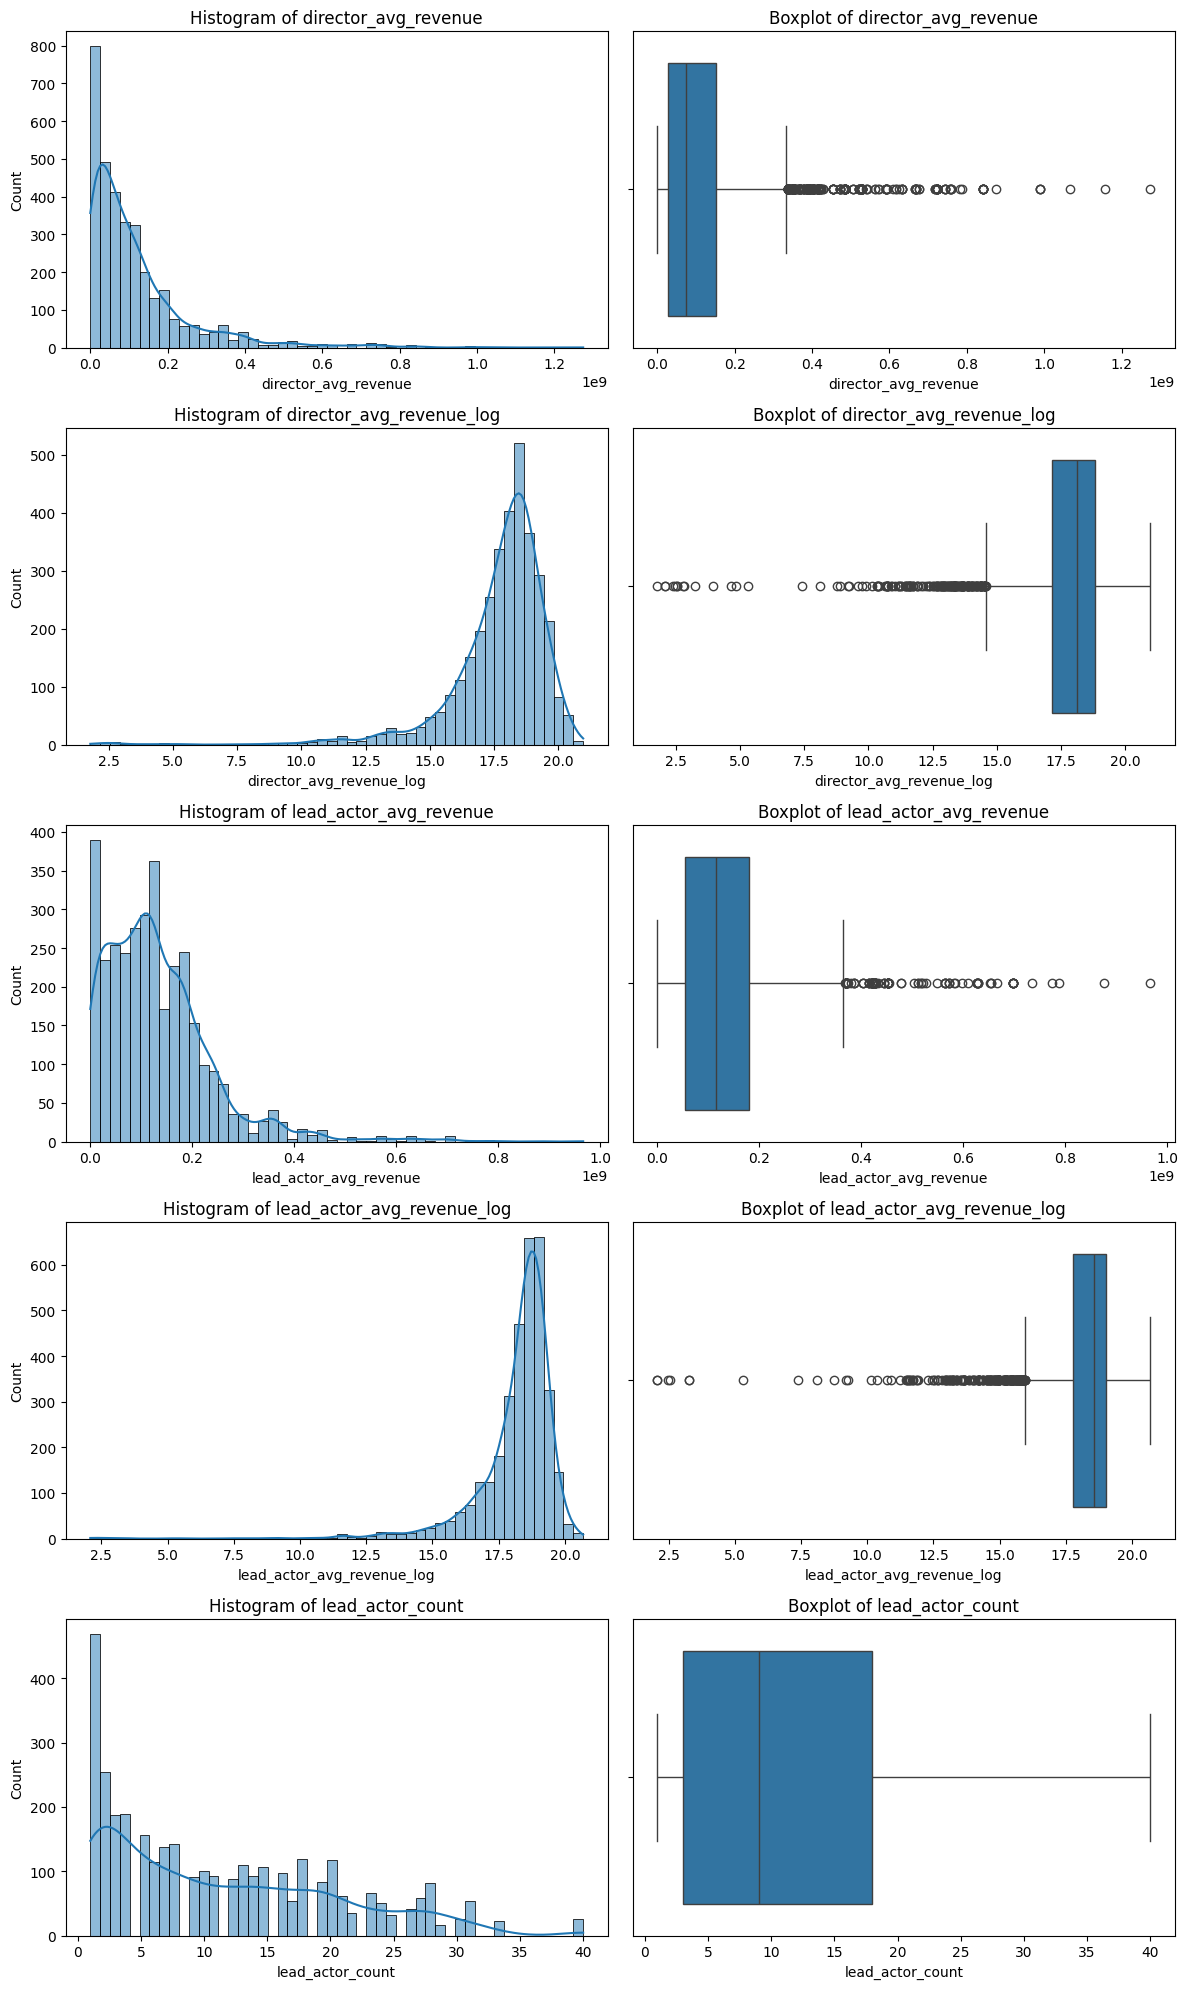

In [18]:
score_columns = [
    'director_avg_revenue',
    'director_avg_revenue_log',
    'lead_actor_avg_revenue',
    'lead_actor_avg_revenue_log',
    'lead_actor_count'
]

df_scored, df2 = get_scores(df, df)
plot_score_distributions(df_scored, score_columns)

The revenue graphs are left-skewed so I have decided to include a log-transformed version of the revenue columns in the dataframe to see if the transformed values perform better in the context of the eventual model.

# Model Selection

## Plan

Ridge vs Lasso vs Elastic Net, RandomForests, XGBoost, LightGBM, KNearestNeighbors
Train, tune, and compare them all. Use the same validation set for each model.
RMSE, MAE, R^2
Comment briefly on speed, interpretability, and feature importance for each

## First steps

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [20]:
y = df['revenue']
X_tr, X_te, y_train, y_test = train_test_split(df, y)
X_train, X_test = get_scores(X_tr, X_te)
X_train = X_train.drop(columns=['revenue', 'release_date', 'movie_id', 'title', 'director', 'lead_actor', 'second_actor', 'third_actor'])
X_test = X_test.drop(columns=['revenue', 'release_date', 'movie_id', 'title', 'director', 'lead_actor', 'second_actor', 'third_actor'])
print(X_train.columns)

Index(['budget', 'popularity', 'runtime', 'genre_Action', 'genre_Adventure',
       'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Family',
       'genre_Horror', 'genre_Other', 'genre_Romance', 'genre_Science Fiction',
       'genre_Thriller', 'award_season', 'summer_blockbuster',
       'winter_low_season', 'likely_sequel', 'num_prev_films_by_director',
       'production_company_Columbia Pictures',
       'production_company_Metro-Goldwyn-Mayer (MGM)',
       'production_company_New Line Cinema', 'production_company_Other',
       'production_company_Paramount Pictures',
       'production_company_Relativity Media',
       'production_company_Touchstone Pictures',
       'production_company_Twentieth Century Fox Film Corporation',
       'production_company_Universal Pictures',
       'production_company_Walt Disney Pictures',
       'production_company_Warner Bros.', 'director_avg_revenue',
       'lead_actor_avg_revenue', 'lead_actor_count',
       'second_actor_avg_revenue'

## Ridge vs Lasso vs Elastic Net

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = np.logspace(-3, 3, 100)

ridge = RidgeCV(alphas=alphas, cv=5).fit(X_train_scaled, y_train)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=10000).fit(X_train_scaled, y_train)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .7, .9, 1], cv=5, max_iter=10000).fit(X_train_scaled, y_train)

/Users/greysonmeyer/miniconda3/envs/Poetry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0661325271932928e+16, tolerance: 7863046580857596.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/greysonmeyer/miniconda3/envs/Poetry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1686708384872448e+16, tolerance: 7418791274377890.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/greysonmeyer/miniconda3/envs/Poetry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4267273581805568e+16, tolerance: 6109376748283486.0
  model = cd_fast.enet_coordinate_descen

Now we evaluate and compare.

In [22]:
models = {
    'Ridge': ridge,
    'Lasso': lasso,
    'ElasticNet': elastic
}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}:\n  Best Alpha: {model.alpha_:.4f}")
    if name == 'ElasticNet':
        print(f"  Best l1_ratio: {model.l1_ratio_:.2f}")
    print(f"  RMSE: {rmse:.2f}\n  R²: {r2:.2f}\n")

Ridge:
  Best Alpha: 162.9751
  RMSE: 112473811.93
  R²: 0.50

Lasso:
  Best Alpha: 1000.0000
  RMSE: 114122156.01
  R²: 0.48

ElasticNet:
  Best Alpha: 0.5337
  Best l1_ratio: 0.90
  RMSE: 112697633.32
  R²: 0.49



It looks like ElasticNet did the best. Interesting how they all had the same R^2 values. Let's take a look at which coefficients survived regularization

In [23]:
pd.Series(lasso.coef_, index=X_train.columns).abs().sort_values()

winter_low_season                                            0.000000e+00
award_season                                                 2.466078e+05
third_actor_count                                            4.297626e+05
genre_Crime                                                  9.141546e+05
genre_Family                                                 9.185446e+05
production_company_Universal Pictures                        1.131600e+06
production_company_Paramount Pictures                        1.168176e+06
genre_Action                                                 1.266278e+06
second_actor_avg_revenue_log                                 1.604855e+06
production_company_Walt Disney Pictures                      1.659951e+06
genre_Romance                                                1.751131e+06
production_company_Metro-Goldwyn-Mayer (MGM)                 1.881994e+06
genre_Adventure                                              1.882717e+06
production_company_New Line Cinema    

Well, it looks like winter_low_season was a dud. Might as well remove that feature. There are currently log-transformed versions of a couple of the features. I the interest of curbing redundancy, I will remove one of the two versions for each pair. I will always choose to remove the version with the smallest coefficient.

In [24]:
X_train = X_train.drop(columns=['winter_low_season', 'director_avg_revenue_log', 'second_actor_avg_revenue_log', 'third_actor_avg_revenue_log', 'lead_actor_avg_revenue_log'])
X_test = X_test.drop(columns=['winter_low_season', 'director_avg_revenue_log', 'second_actor_avg_revenue_log', 'third_actor_avg_revenue_log', 'lead_actor_avg_revenue_log'])

In [25]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

elastic = ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .7, .9, 1], cv=5, max_iter=10000).fit(X_train_scaled, y_train)
y_pred = elastic.predict(X_test_scaled)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Best Alpha: {model.alpha_:.4f}')
print(f"  Best l1_ratio: {model.l1_ratio_:.2f}")
print(f"  RMSE: {rmse:.2f}\n  R²: {r2:.2f}\n")

Best Alpha: 0.5337
  Best l1_ratio: 0.90
  RMSE: 113760551.34
  R²: 0.48



Here is the winner!

In [26]:
elastic = ElasticNet(alpha=0.087, l1_ratio=0.5)

Now let's use PolynomialFeatures to see if there are any interaction terms that could make our model better.

In [27]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction = poly.fit_transform(X_train_scaled)
X_test_interaction = poly.fit_transform(X_test_scaled)
feature_names = poly.get_feature_names_out(X_train.columns)

elastic.fit(X_train_interaction, y_train)
y_pred = elastic.predict(X_test_interaction)
mse = mean_squared_error(y_test, y_pred, squared=False)
print("MSE with interaction terms:", mse)

MSE with interaction terms: 113632340.2161208


/Users/greysonmeyer/miniconda3/envs/Poetry/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+18, tolerance: 9.237e+15
  model = cd_fast.enet_coordinate_descent(


Including all of the interaction terms increased the RMSE, so I will omit any interaction terms for now. It is important to note that there still could be some interaction terms that could make the model better, but it will require closer analysis and an appeal to my domain knowledge. I will pursue this another time. An upside is that this model was extremely quick to fit and predict compared to other models down the line.

## Random Forests

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

We start by initializing a baseline model so that we can get feature_importance scores that will make our data more useful during the hyperparameter tuning later on.

In [29]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R^2:", r2_score(y_test, y_pred))

RMSE: 117520307.16964759
R^2: 0.4503195530847969


Now we check feature importance scores

In [30]:
importances = forest.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print(feat_imp)

director_avg_revenue                                         0.511766
third_actor_avg_revenue                                      0.130909
popularity                                                   0.112622
budget                                                       0.090163
second_actor_avg_revenue                                     0.042935
lead_actor_avg_revenue                                       0.028747
runtime                                                      0.019352
third_actor_count                                            0.012717
second_actor_count                                           0.010237
production_company_Twentieth Century Fox Film Corporation    0.008106
lead_actor_count                                             0.007486
num_prev_films_by_director                                   0.005560
genre_Other                                                  0.002077
genre_Thriller                                               0.001641
production_company_P

In [31]:
X_train = X_train.drop(columns=['genre_Drama', 'production_company_Walt Disney Pictures', 'genre_Romance', 'genre_Family', 'genre_Comedy', 'production_company_Warner Bros.', 'genre_Crime', 'production_company_Columbia Pictures', 'production_company_Paramount Pictures', 'production_company_Relativity Media', 'production_company_Touchstone Pictures', 'production_company_Other', 'production_company_New Line Cinema', 'genre_Horror', 'production_company_Metro-Goldwyn-Mayer (MGM)'])
X_test = X_test.drop(columns=['genre_Drama', 'production_company_Walt Disney Pictures', 'genre_Romance', 'genre_Family', 'genre_Comedy', 'production_company_Warner Bros.', 'genre_Crime', 'production_company_Columbia Pictures', 'production_company_Paramount Pictures', 'production_company_Relativity Media', 'production_company_Touchstone Pictures', 'production_company_Other', 'production_company_New Line Cinema', 'genre_Horror', 'production_company_Metro-Goldwyn-Mayer (MGM)'])

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

search = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                            param_distributions=param_dist,
                            n_iter=50,
                            cv=5,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1)
search.fit(X_train, y_train)
best_forest = search.best_estimator_


In [ ]:
scores = cross_val_score(best_forest, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Average RMSE:", -scores.mean())

Average RMSE: 71126604.23399362


It appears that random forests show a marked improvement over the ElasticNet model. Let's now check for hetereoscedasticity that could be a sign that something is not right with our model.

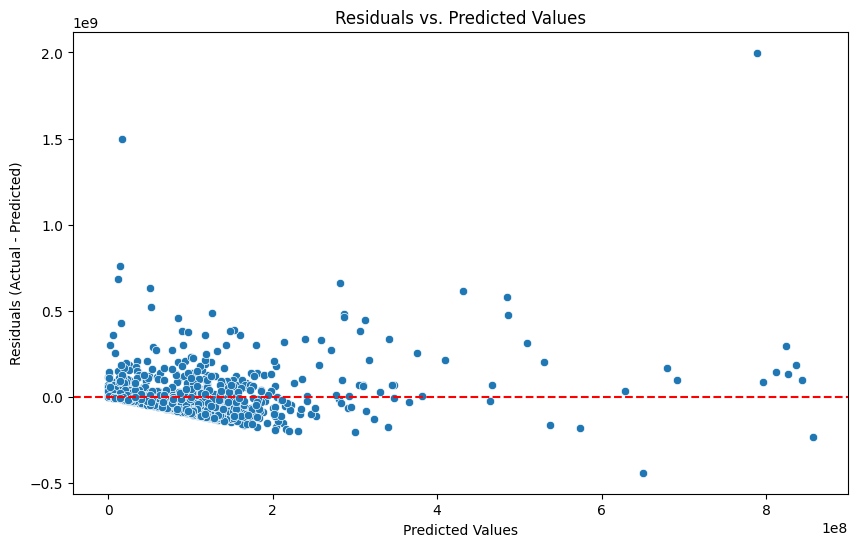

In [ ]:
y_pred = best_forest.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')  # Reference line at zero
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values")
plt.show()


I don't see any clear funneling behavior, so I think everything is ok.

## XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    n_iter=30,
    cv=5,
    verbose=1,
    n_jobs=-1
)
search.fit(X_train, y_train)
best_XGB = search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


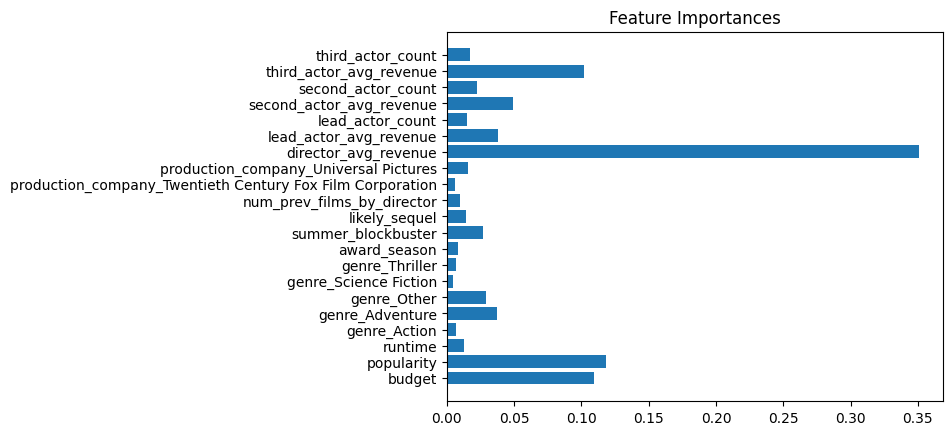

In [ ]:
importances = best_XGB.feature_importances_
plt.barh(X_train.columns, importances)
plt.title("Feature Importances")
plt.show()

In [ ]:
y_pred = best_XGB.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, R²: {r2:.2f}")

RMSE: 145551282.39, R²: 0.47


A little better than the random forest model.

In [ ]:
scores = cross_val_score(best_XGB, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f"CV RMSE: {-scores.mean():.2f} ± {scores.std():.2f}")

CV RMSE: 68345351.75 ± 1238290.60


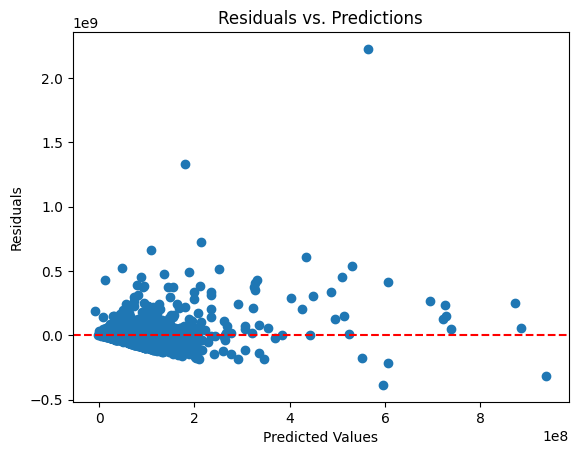

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predictions')
plt.show()


## LightGBM

In [ ]:
from lightgbm import LGBMRegressor

Hyperparameter tuning.

In [ ]:
params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500]
}
grid = RandomizedSearchCV(LGBMRegressor(), params, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)
best_lgb = grid.best_estimator_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 2024, number of used features: 21
[LightGBM] [Info] Start training from score 115563053.997530


/Users/greysonmeyer/miniconda3/envs/Poetry/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1704
[LightGBM] [Info] Number of data points in the train set: 2024, number of used features: 21
[LightGBM] [Info] Start training from score 117345517.552866
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1695
[LightGBM] [Info] Number of data points in the train set: 2024, number of used features: 21
[LightGBM] [Info] Start training from score 117049072.253953
[LightGBM] [Wa

In [ ]:
y_pred = best_lgb.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²:", r2_score(y_test, y_pred))


RMSE: 139997206.30581164
R²: 0.5066146677489858


This is the best RMSE yet!

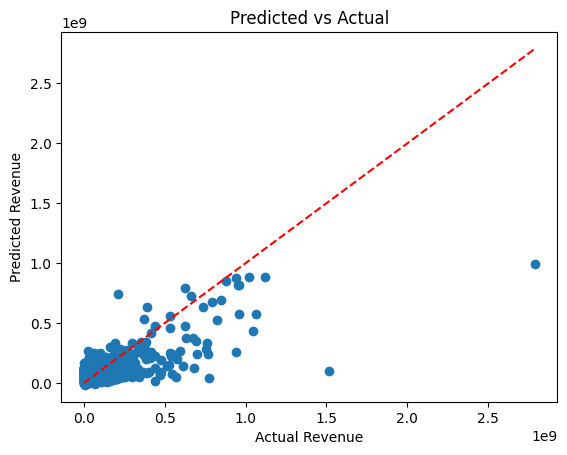

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.show()


## KNearestNeighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
param_grid = {'n_neighbors': np.arange(1, 31)}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train_scaled, y_train)

print("Best k:", grid.best_params_['n_neighbors'])
print("Best CV score (RMSE):", -grid.best_score_)

Best k: 7
Best CV score (RMSE): 89201882.42587467


In [ ]:
best_knn = KNeighborsRegressor(n_neighbors=6)
best_knn.fit(X_train_scaled, y_train)
y_pred = best_knn.predict(X_test_scaled)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Test RMSE:", rmse)
print("Test R² Score:", r2)

Test RMSE: 142689531.01997018
Test R² Score: 0.48745533557823273


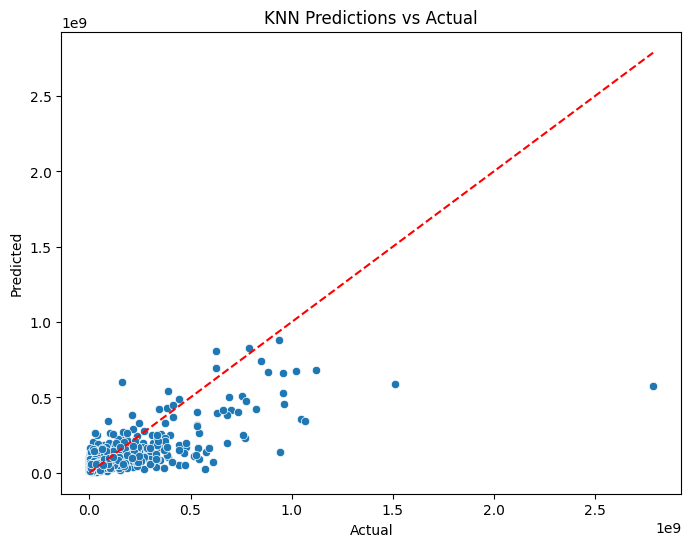

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("KNN Predictions vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

## Model Comparisons

In [ ]:
models = {"Elastic Net": elastic, "Random Forest": best_forest, "XGBoost": best_XGB, "LightGBM": best_lgb, "KNN": best_knn}
for m in models:
    models[m].fit(X_train, y_train)
    y_pred = models[m].predict(X_test)
    print(m, ': RMSE ', mean_squared_error(y_test, y_pred, squared=False), ', R^2: ', r2_score(y_test, y_pred), ', MAE: ', mean_absolute_error(y_test, y_pred))

ValueError: could not convert string to float: 'train'

It appears that LightGBM is the winner!

# Feature Analysis Performed In Tableau

To explore why our models struggled to provide accurate predictions, we will export our data to Tableau to perform feature analysis to see what exactly is occurring behind the scenes.

# Final Steps

SHAP
Tableau
Split the file into smaller files?
make the repo nice